<a href="https://colab.research.google.com/github/doyooni303/NewNLPStudy/blob/main/%5BPytorch_NLP%5D_word_embeddings_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline


Word Embeddings: Encoding Lexical Semantics
===========================================

Word embeddings are dense vectors of real numbers, one per word in your
vocabulary. In NLP, it is almost always the case that your features are
words! But how should you represent a word in a computer? You could
store its ascii character representation, but that only tells you what
the word *is*, it doesn't say much about what it *means* (you might be
able to derive its part of speech from its affixes, or properties from
its capitalization, but not much). Even more, in what sense could you
combine these representations? We often want dense outputs from our
neural networks, where the inputs are $|V|$ dimensional, where
$V$ is our vocabulary, but often the outputs are only a few
dimensional (if we are only predicting a handful of labels, for
instance). How do we get from a massive dimensional space to a smaller
dimensional space?

How about instead of ascii representations, we use a one-hot encoding?
That is, we represent the word $w$ by

\begin{align}\overbrace{\left[ 0, 0, \dots, 1, \dots, 0, 0 \right]}^\text{|V| elements}\end{align}

where the 1 is in a location unique to $w$. Any other word will
have a 1 in some other location, and a 0 everywhere else.

There is an enormous drawback to this representation, besides just how
huge it is. It basically treats all words as independent entities with
no relation to each other. What we really want is some notion of
*similarity* between words. Why? Let's see an example.

Suppose we are building a language model. Suppose we have seen the
sentences

* The mathematician ran to the store.
* The physicist ran to the store.
* The mathematician solved the open problem.

in our training data. Now suppose we get a new sentence never before
seen in our training data:

* The physicist solved the open problem.

Our language model might do OK on this sentence, but wouldn't it be much
better if we could use the following two facts:

* We have seen  mathematician and physicist in the same role in a sentence. Somehow they
  have a semantic relation.
* We have seen mathematician in the same role  in this new unseen sentence
  as we are now seeing physicist.

and then infer that physicist is actually a good fit in the new unseen
sentence? This is what we mean by a notion of similarity: we mean
*semantic similarity*, not simply having similar orthographic
representations. It is a technique to combat the sparsity of linguistic
data, by connecting the dots between what we have seen and what we
haven't. This example of course relies on a fundamental linguistic
assumption: that words appearing in similar contexts are related to each
other semantically. This is called the `distributional
hypothesis <https://en.wikipedia.org/wiki/Distributional_semantics>`__.


Getting Dense Word Embeddings

How can we solve this problem? That is, how could we actually encode
semantic similarity in words? Maybe we think up some semantic
attributes. For example, we see that both mathematicians and physicists
can run, so maybe we give these words a high score for the "is able to
run" semantic attribute. Think of some other attributes, and imagine
what you might score some common words on those attributes.

If each attribute is a dimension, then we might give each word a vector,
like this:

\begin{align}q_\text{mathematician} = \left[ \overbrace{2.3}^\text{can run},
   \overbrace{9.4}^\text{likes coffee}, \overbrace{-5.5}^\text{majored in Physics}, \dots \right]\end{align}

\begin{align}q_\text{physicist} = \left[ \overbrace{2.5}^\text{can run},
   \overbrace{9.1}^\text{likes coffee}, \overbrace{6.4}^\text{majored in Physics}, \dots \right]\end{align}

Then we can get a measure of similarity between these words by doing:

\begin{align}\text{Similarity}(\text{physicist}, \text{mathematician}) = q_\text{physicist} \cdot q_\text{mathematician}\end{align}

Although it is more common to normalize by the lengths:

\begin{align}\text{Similarity}(\text{physicist}, \text{mathematician}) = \frac{q_\text{physicist} \cdot q_\text{mathematician}}
   {\| q_\text{physicist} \| \| q_\text{mathematician} \|} = \cos (\phi)\end{align}

Where $\phi$ is the angle between the two vectors. That way,
extremely similar words (words whose embeddings point in the same
direction) will have similarity 1. Extremely dissimilar words should
have similarity -1.


You can think of the sparse one-hot vectors from the beginning of this
section as a special case of these new vectors we have defined, where
each word basically has similarity 0, and we gave each word some unique
semantic attribute. These new vectors are *dense*, which is to say their
entries are (typically) non-zero.

But these new vectors are a big pain: you could think of thousands of
different semantic attributes that might be relevant to determining
similarity, and how on earth would you set the values of the different
attributes? Central to the idea of deep learning is that the neural
network learns representations of the features, rather than requiring
the programmer to design them herself. So why not just let the word
embeddings be parameters in our model, and then be updated during
training? This is exactly what we will do. We will have some *latent
semantic attributes* that the network can, in principle, learn. Note
that the word embeddings will probably not be interpretable. That is,
although with our hand-crafted vectors above we can see that
mathematicians and physicists are similar in that they both like coffee,
if we allow a neural network to learn the embeddings and see that both
mathematicians and physicists have a large value in the second
dimension, it is not clear what that means. They are similar in some
latent semantic dimension, but this probably has no interpretation to
us.


In summary, **word embeddings are a representation of the *semantics* of
a word, efficiently encoding semantic information that might be relevant
to the task at hand**. You can embed other things too: part of speech
tags, parse trees, anything! The idea of feature embeddings is central
to the field.


Word Embeddings in Pytorch


Before we get to a worked example and an exercise, a few quick notes
about how to use embeddings in Pytorch and in deep learning programming
in general. Similar to how we defined a unique index for each word when
making one-hot vectors, we also need to define an index for each word
when using embeddings. These will be keys into a lookup table. That is,
embeddings are stored as a $|V| \times D$ matrix, where $D$
is the dimensionality of the embeddings, such that the word assigned
index $i$ has its embedding stored in the $i$'th row of the
matrix. In all of my code, the mapping from words to indices is a
dictionary named word\_to\_ix.

The module that allows you to use embeddings is torch.nn.Embedding,
which takes two arguments: the vocabulary size, and the dimensionality
of the embeddings.

To index into this table, you must use torch.LongTensor (since the
indices are integers, not floats).




# Word Embedding Process

In [ ]:
# Author: Robert Guthrie

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [ ]:
word_to_ix = {"hello": 0, "world": 1}
#embeds = nn.Embedding(2, 5)  # 2 words in vocab, 5 dimensional embeddings
embeds = nn.Embedding(3, 4)  # 2 words in vocab, 5 dimensional embeddings
lookup_tensor = torch.tensor([i for i in word_to_ix.values()], dtype=torch.long)
hello_embed = embeds(lookup_tensor)
print(hello_embed)

tensor([[ 0.6614,  0.2669,  0.0617,  0.6213],
        [-0.4519, -0.1661, -1.5228,  0.3817]], grad_fn=<EmbeddingBackward>)


# An Example: N-Gram Language Modeling

Recall that in an n-gram language model, given a sequence of words
$w$, we want to compute

\begin{align}P(w_i | w_{i-1}, w_{i-2}, \dots, w_{i-n+1} )\end{align}

Where $w_i$ is the ith word of the sequence.

In this example, we will compute the loss function on some training
examples and update the parameters with backpropagation.




In [ ]:

# We will use Shakespeare Sonnet 2
test_sentence = """When forty winters shall besiege thy brow,
And dig deep trenches in thy beauty's field,
Thy youth's proud livery so gazed on now,
Will be a totter'd weed of small worth held:
Then being asked, where all thy beauty lies,
Where all the treasure of thy lusty days;
To say, within thine own deep sunken eyes,
Were an all-eating shame, and thriftless praise.
How much more praise deserv'd thy beauty's use,
If thou couldst answer 'This fair child of mine
Shall sum my count, and make my old excuse,'
Proving his beauty by succession thine!
This were to be new made when thou art old,
And see thy blood warm when thou feel'st it cold.""".split()

test_sentence,len(test_sentence),type(test_sentence[0])



(['When',
  'forty',
  'winters',
  'shall',
  'besiege',
  'thy',
  'brow,',
  'And',
  'dig',
  'deep',
  'trenches',
  'in',
  'thy',
  "beauty's",
  'field,',
  'Thy',
  "youth's",
  'proud',
  'livery',
  'so',
  'gazed',
  'on',
  'now,',
  'Will',
  'be',
  'a',
  "totter'd",
  'weed',
  'of',
  'small',
  'worth',
  'held:',
  'Then',
  'being',
  'asked,',
  'where',
  'all',
  'thy',
  'beauty',
  'lies,',
  'Where',
  'all',
  'the',
  'treasure',
  'of',
  'thy',
  'lusty',
  'days;',
  'To',
  'say,',
  'within',
  'thine',
  'own',
  'deep',
  'sunken',
  'eyes,',
  'Were',
  'an',
  'all-eating',
  'shame,',
  'and',
  'thriftless',
  'praise.',
  'How',
  'much',
  'more',
  'praise',
  "deserv'd",
  'thy',
  "beauty's",
  'use,',
  'If',
  'thou',
  'couldst',
  'answer',
  "'This",
  'fair',
  'child',
  'of',
  'mine',
  'Shall',
  'sum',
  'my',
  'count,',
  'and',
  'make',
  'my',
  'old',
  "excuse,'",
  'Proving',
  'his',
  'beauty',
  'by',
  'succession',
  

In [ ]:
# we should tokenize the input, but we will ignore that for now
# build a list of tuples.  Each tuple is ([ word_i-2, word_i-1 ], target word)
trigrams = [([test_sentence[i], test_sentence[i + 1]], test_sentence[i + 2])
            for i in range(len(test_sentence) - 2)]
# print the first 3, just so you can see what they look like
print(type(trigrams),trigrams[:3])



<class 'list'> [(['When', 'forty'], 'winters'), (['forty', 'winters'], 'shall'), (['winters', 'shall'], 'besiege')]


In [ ]:
vocab = set(test_sentence) #이게 리얼 Corpus 구먼
#for word in vocab:
#  print(word)
word_to_ix = {word: i for i, word in enumerate(vocab)} #순서는 맨처음 torch.manual(1)에 의해서 정해짐
len(vocab)

97

In [ ]:
class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim) #이것이 포인트여: 자동 임베딩
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1)) # context를 옆으로 붙이는거
        #print(embeds.shape)
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs


In [ ]:
CONTEXT_SIZE = 2
EMBEDDING_DIM = 10
VOCAB_SIZE = len(vocab)

losses,accuracy = [],[]
loss_function = nn.NLLLoss()
model = NGramLanguageModeler(VOCAB_SIZE, EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.001,momentum=0.9)

for epoch in range(100):
    total_loss = 0
    total_acc = 0
    for context, target in trigrams:

        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long) #since it's trigram, there are 2 words in context

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old
        # instance
        model.zero_grad()
        running_corrects=0
        # Step 3. Run the forward pass, getting log probabilities over next
        # words
        log_probs = model(context_idxs)
        _, preds = torch.max(log_probs, 1)
        running_corrects += torch.sum(preds == word_to_ix[target])
        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a tensor)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()
        total_acc += running_corrects 
    
    avg_loss= total_loss/len(trigrams)
    avg_acc = total_acc / len(trigrams)
    
    print(f'Epoch {epoch+1}::Accuracy={avg_acc}, loss={avg_loss}')
    losses.append(avg_loss)
    accuracy.append(avg_acc)

#print(losses)  # The loss decreased every iteration over the training data!

Epoch 1::Accuracy=0.017699114978313446, loss=4.65038985699679
Epoch 2::Accuracy=0.08849557489156723, loss=4.450681279190873
Epoch 3::Accuracy=0.1150442510843277, loss=4.260537181280355
Epoch 4::Accuracy=0.14159291982650757, loss=4.074205592670272
Epoch 5::Accuracy=0.16814158856868744, loss=3.887594039461254
Epoch 6::Accuracy=0.2300885021686554, loss=3.6970807493260476
Epoch 7::Accuracy=0.3008849620819092, loss=3.500292313837372
Epoch 8::Accuracy=0.36283186078071594, loss=3.2956222659718675
Epoch 9::Accuracy=0.45132744312286377, loss=3.0821795236747875
Epoch 10::Accuracy=0.47787609696388245, loss=2.860807236580722
Epoch 11::Accuracy=0.6017699241638184, loss=2.6329904275130382
Epoch 12::Accuracy=0.6725663542747498, loss=2.4013253479404786
Epoch 13::Accuracy=0.7079645991325378, loss=2.16870086145612
Epoch 14::Accuracy=0.8230088353157043, loss=1.9392752708059497
Epoch 15::Accuracy=0.8672566413879395, loss=1.7166001525072925
Epoch 16::Accuracy=0.9026548862457275, loss=1.5048416214706624
Epo

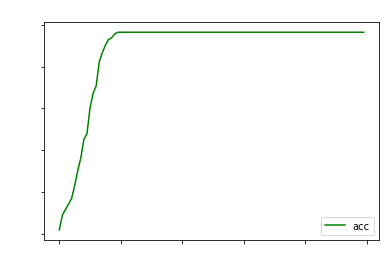

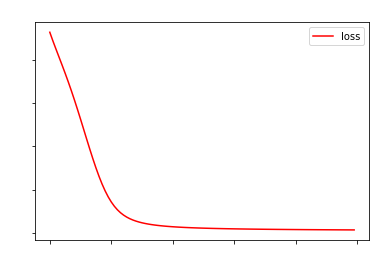

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.title('Accuracy',color='white')
plt.plot(accuracy, 'g', label='acc')
plt.xlabel('Epochs',color='white')
plt.ylabel('Acc',color='white')
plt.legend(loc='lower right')
plt.xticks(color='white')
plt.yticks(color='white')
plt.show()

plt.title('Loss',color='white')
plt.plot(losses,'r',label='loss')
plt.xlabel('Epochs',color='white')
plt.ylabel('Loss',color='white')
plt.legend()
plt.xticks(color='white')
plt.yticks(color='white')
plt.show()

# Exercise: Computing Word Embeddings: Continuous Bag-of-Words

The Continuous Bag-of-Words model (CBOW) is frequently used in NLP deep
learning. It is a model that tries to predict words given the context of
a few words before and a few words after the target word. This is
distinct from language modeling, since CBOW is not sequential and does
not have to be probabilistic. Typcially, CBOW is used to quickly train
word embeddings, and these embeddings are used to initialize the
embeddings of some more complicated model. Usually, this is referred to
as *pretraining embeddings*. It almost always helps performance a couple
of percent.

The CBOW model is as follows. Given a target word $w_i$ and an
$N$ context window on each side, $w_{i-1}, \dots, w_{i-N}$
and $w_{i+1}, \dots, w_{i+N}$, referring to all context words
collectively as $C$, CBOW tries to minimize

\begin{align}-\log p(w_i | C) = -\log \text{Softmax}(A(\sum_{w \in C} q_w) + b)\end{align}

where $q_w$ is the embedding for word $w$.

Implement this model in Pytorch by filling in the class below. Some
tips:

* Think about which parameters you need to define.
* Make sure you know what shape each operation expects. Use .view() if you need to
  reshape.




In [ ]:
CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right
raw_text = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells.""".split()

# By deriving a set from `raw_text`, we deduplicate the array
vocab = set(raw_text)
vocab_size = len(vocab)

type(raw_text),vocab,vocab_size

(list,
 {'As',
  'Computational',
  'In',
  'People',
  'The',
  'We',
  'a',
  'about',
  'abstract',
  'are',
  'beings',
  'by',
  'called',
  'computational',
  'computer',
  'computers.',
  'conjure',
  'create',
  'data.',
  'direct',
  'directed',
  'effect,',
  'evolution',
  'evolve,',
  'idea',
  'inhabit',
  'is',
  'manipulate',
  'of',
  'other',
  'our',
  'pattern',
  'process',
  'process.',
  'processes',
  'processes.',
  'program.',
  'programs',
  'rules',
  'spells.',
  'spirits',
  'study',
  'that',
  'the',
  'they',
  'things',
  'to',
  'we',
  'with'},
 49)

In [ ]:
a=[1,2,4,8,69]
del a[3]
print(a)

list(range(CONTEXT_SIZE,-(CONTEXT_SIZE+1),-1))

[1, 2, 4, 69]


[2, 1, 0, -1, -2]

In [ ]:
word_to_ix = {word: i for i, word in enumerate(vocab)}
ix_to_word = {ix:word for ix, word in enumerate(vocab)}
data = []
for i in range(CONTEXT_SIZE, len(raw_text) - CONTEXT_SIZE):
    #context = [raw_text[i - 2], raw_text[i - 1],
    #           raw_text[i + 1], raw_text[i + 2]]

    context= [raw_text[i-j] for j in range(CONTEXT_SIZE,-(CONTEXT_SIZE+1),-1) ]
    del context[CONTEXT_SIZE]            
    target = raw_text[i]
    data.append((context, target))

print(data[:5])
print(len(vocab),len(word_to_ix),len(data))





[(['We', 'are', 'to', 'study'], 'about'), (['are', 'about', 'study', 'the'], 'to'), (['about', 'to', 'the', 'idea'], 'study'), (['to', 'study', 'idea', 'of'], 'the'), (['study', 'the', 'of', 'a'], 'idea')]
49 49 58


In [ ]:
# tensor를 행,열을 바꿔줌
a=torch.tensor([[1,2,3],[4,5,6]])
torch.rot90(a,-1,[0,1])

tensor([[4, 1],
        [5, 2],
        [6, 3]])

In [ ]:
class CBOW(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW, self).__init__()

        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, 128)
        self.activation1 = nn.ReLU()
        
        #out: 1 x vocab_size
        self.linear2 = nn.Linear(128, vocab_size)
        self.activation2 = nn.LogSoftmax(dim = -1)
        

    def forward(self, inputs):
        embeds = sum(self.embeddings(inputs)).view(1,-1)
        out = self.linear1(embeds)
        out = self.activation1(out)
        out = self.linear2(out)
        out = self.activation2(out)
        return out

    def get_word_emdedding(self, word):
        word = torch.tensor([word_to_ix[word]])
        return self.embeddings(word).view(1,-1)



def make_context_vector(context, word_to_ix):
    idxs = [word_to_ix[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)


input=make_context_vector(data[0][0], word_to_ix)  # example
#model.get_word_emdedding(data[0][0])

In [ ]:
embeddings= nn.Embedding(49, 10) # 49=vocabsize, 10=embedding dimension
input=torch.tensor([ 8, 34, 40, 16]) # example

print(input)
print(embeddings)
print(embeddings(input))
print(embeddings(input).shape)




tensor([ 8, 34, 40, 16])
Embedding(49, 10)
tensor([[ 0.7464,  0.2328,  0.0054,  0.1899, -0.2596, -1.7663,  0.8808, -1.4067,
         -0.3111,  0.3290],
        [ 0.1317,  0.4890, -1.2848, -0.3952, -0.3694, -0.3983,  0.4598,  0.0107,
         -0.0460,  0.5487],
        [ 1.0015, -0.9535, -0.1564,  0.2379, -0.0025,  0.0109,  1.1535,  0.2307,
         -0.9663, -0.2421],
        [ 0.3373,  1.1636, -0.3324,  0.5396,  0.5268,  0.5086,  0.1116, -1.5343,
         -0.2941, -0.0317]], grad_fn=<EmbeddingBackward>)
torch.Size([4, 10])


In [ ]:
vocab_size=len(vocab)
embedding_dim= 10
print(vocab_size,embedding_dim)
input=make_context_vector(data[0][0], word_to_ix)  # example
print(input)
embeddings= nn.Embedding(vocab_size, embedding_dim)
embeddings.weight[0],len(embeddings.weight[0])

49 10
tensor([ 8, 34, 40, 16])


(tensor([-1.5256, -0.7502, -0.6540, -1.6095, -0.1002, -0.6092, -0.9798, -1.6091,
         -0.7121,  0.3037], grad_fn=<SelectBackward>), 10)

In [ ]:
embdedding_size = 10
vocab_size = len(vocab)

losses,accuracy = [],[]
loss_function = nn.NLLLoss()
model = CBOW(vocab_size, embedding_dim)
optimizer = optim.SGD(model.parameters(), lr=0.001,momentum=0.9)


for epoch in range(100):
    total_loss = 0
    total_acc = 0
    
    for context, target in data:

        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)
        context_idxs = make_context_vector(context,word_to_ix) # size2*WindowSize의 list 출력

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old
        # instance
        optimizer.zero_grad()
        acc=0
        # Step 3. Run the forward pass, getting log probabilities over next
        # words
        log_probs = model(context_idxs)
        
        #tensor([[-2.0541e+01, -1.7539e+01, -6.4471e+00, -1.7899e+01, -7.4570e+00,
        #        ,,,
        #        -1.5753e+01, -1.8592e+01, -1.3573e+01, -1.9317e+01]], grad_fn=<LogSoftmaxBackward>)
        
        _, preds = torch.max(log_probs, 1)
        # _,preds = tensor([-0.0114], grad_fn=<MaxBackward0>),tensor([5]))
        acc += torch.sum(preds == word_to_ix[target])
        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a tensor)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()
        total_acc += acc 
    
    avg_loss= total_loss/len(data)
    avg_acc = total_acc / len(data)
    
    print(f'Epoch {epoch+1}::Accuracy={avg_acc}, loss={avg_loss}')
    losses.append(avg_loss)
    accuracy.append(avg_acc)

#print(losses)  # The loss decreased every iteration over the training data!

Epoch 1::Accuracy=0.017241379246115685, loss=4.078189578549615
Epoch 2::Accuracy=0.08620689809322357, loss=3.443150618980671
Epoch 3::Accuracy=0.2068965584039688, loss=2.9676163566523583
Epoch 4::Accuracy=0.36206895112991333, loss=2.5760613762099167
Epoch 5::Accuracy=0.43103447556495667, loss=2.239420740768827
Epoch 6::Accuracy=0.5862069129943848, loss=1.9427204275953358
Epoch 7::Accuracy=0.7241379022598267, loss=1.6796317938072929
Epoch 8::Accuracy=0.8275862336158752, loss=1.4472999341528991
Epoch 9::Accuracy=0.8275862336158752, loss=1.2443074198632404
Epoch 10::Accuracy=0.931034505367279, loss=1.0686601811441883
Epoch 11::Accuracy=0.9482758641242981, loss=0.9176312890546076
Epoch 12::Accuracy=0.9655172228813171, loss=0.7888869825622131
Epoch 13::Accuracy=0.9655172228813171, loss=0.6796801593796961
Epoch 14::Accuracy=0.982758641242981, loss=0.5876102360158131
Epoch 15::Accuracy=0.982758641242981, loss=0.5101210698485374
Epoch 16::Accuracy=1.0, loss=0.4449622304788951
Epoch 17::Accurac

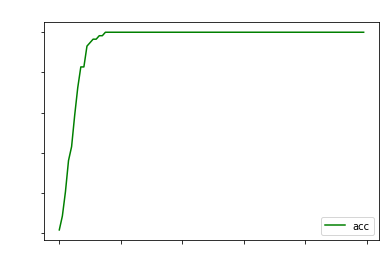

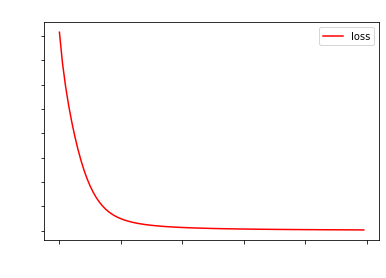

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.title('Accuracy',color='white')
plt.plot(accuracy, 'g', label='acc')
plt.xlabel('Epochs',color='white')
plt.ylabel('Acc',color='white')
plt.legend(loc='lower right')
plt.xticks(color='white')
plt.yticks(color='white')
plt.show()

plt.title('Loss',color='white')
plt.plot(losses,'r',label='loss')
plt.xlabel('Epochs',color='white')
plt.ylabel('Loss',color='white')
plt.legend()
plt.xticks(color='white')
plt.yticks(color='white')
plt.show()

In [ ]:
#TESTING
context = ['People','create','to', 'direct']
context_vector = make_context_vector(context, word_to_ix)
a = model(context_vector)
print(a)
print(torch.max(a,1))
#Print result
print(f'Raw text: {" ".join(raw_text)}\n')
print(f'Context: {context}\n')
print(f'Prediction: {ix_to_word[torch.argmax(a[0]).item()]}')

tensor([[-11.8801, -10.8649,  -8.1733, -10.8978,  -5.9613,  -7.6268, -10.8652,
          -9.6727, -12.8489,  -9.5890,  -7.3727,  -9.8138,  -8.3892, -11.6096,
          -4.6647, -12.2448,  -6.4296,  -9.7634, -12.8779, -10.5833, -12.8029,
         -11.3828, -11.4829,  -9.6844, -12.9790, -13.0752, -11.5717, -12.1594,
          -6.2928, -10.4810, -11.4111, -10.4536, -10.7557,  -7.1621, -11.6999,
         -11.1518,  -7.2715, -10.4384, -11.3888, -11.6783, -11.4464,  -0.0254,
          -7.1546,  -5.5012,  -8.0153,  -7.6675, -11.8563,  -9.9954,  -8.3975]],
       grad_fn=<LogSoftmaxBackward>)
torch.return_types.max(
values=tensor([-0.0254], grad_fn=<MaxBackward0>),
indices=tensor([41]))
Raw text: We are about to study the idea of a computational process. Computational processes are abstract beings that inhabit computers. As they evolve, processes manipulate other abstract things called data. The evolution of a process is directed by a pattern of rules called a program. People create programs t

In [ ]:
import numpy as np
np.shape(model.state_dict()['embeddings.weight'])

torch.Size([49, 10])

In [ ]:
class BoWClassifier(nn.Module):  # inheriting from nn.Module!

    def __init__(self, num_labels, vocab_size):
        # calls the init function of nn.Module.  Dont get confused by syntax,
        # just always do it in an nn.Module
        super(BoWClassifier, self).__init__()

        # Define the parameters that you will need.  In this case, we need A and b,
        # the parameters of the affine mapping.
        # Torch defines nn.Linear(), which provides the affine map.
        # Make sure you understand why the input dimension is vocab_size
        # and the output is num_labels!
        self.linear = nn.Linear(vocab_size, num_labels)

        # NOTE! The non-linearity log softmax does not have parameters! So we don't need
        # to worry about that here

    def forward(self, bow_vec):
        # Pass the input through the linear layer,
        # then pass that through log_softmax.
        # Many non-linearities and other functions are in torch.nn.functional
        return F.log_softmax(self.linear(bow_vec), dim=1)


def make_bow_vector(sentence, word_to_ix):
    vec = torch.zeros(len(word_to_ix))
    for word in sentence:
        vec[word_to_ix[word]] += 1
    return vec.view(1, -1)


def make_target(label, label_to_ix):
    return torch.LongTensor([label_to_ix[label]])

# Example of Skip gram

## Data 불러오기

In [ ]:
# API Token 다운받기
# 다운받은 API Token 업로드 하기
!pip install kaggle
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"doyooni303","key":"91fac564146b8719aa4482ee9779aca2"}'}

In [ ]:
# json 파일 옮겨주기
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json
# 본인이 참가한 모든 대회 보기 
#!kaggle competitions list
# 데이터셋 다운로드 받기 - 링크는 그 대회 'Data'에 있음
! kaggle datasets download -d ashukr/word2vec-data
# 다운로드 된 것들 다 보기 
!ls
# 필요하면 압축 풀기 
!unzip word2vec-data.zip

  0% 0.00/3.32M [00:00<?, ?B/s]
100% 3.32M/3.32M [00:00<00:00, 112MB/s]
cache  dialogue-lines-of-the-simpsons.zip  kaggle.json	sample_data
Archive:  dialogue-lines-of-the-simpsons.zip
  inflating: simpsons_dataset.csv    


In [ ]:
def preprocess(text):

    # Replace punctuation with tokens so we can use them in our model
    text = text.lower()
    text = text.replace('.', ' <PERIOD> ')
    text = text.replace(',', ' <COMMA> ')
    text = text.replace('"', ' <QUOTATION_MARK> ')
    text = text.replace(';', ' <SEMICOLON> ')
    text = text.replace('!', ' <EXCLAMATION_MARK> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace('(', ' <LEFT_PAREN> ')
    text = text.replace(')', ' <RIGHT_PAREN> ')
    text = text.replace('--', ' <HYPHENS> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    # text = text.replace('\n', ' <NEW_LINE> ')
    text = text.replace(':', ' <COLON> ')
    words = text.split()
    
    # Remove all words with  5 or fewer occurences
    word_counts = Counter(words)
    trimmed_words = [word for word in words if word_counts[word] > 5]

    return trimmed_words


def create_lookup_tables(words):
    """
    Create lookup tables for vocabulary
    :param words: Input list of words
    :return: Two dictionaries, vocab_to_int, int_to_vocab
    """
    word_counts = Counter(words)
    # sorting the words from most to least frequent in text occurrence
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    # create int_to_vocab dictionaries
    int_to_vocab = {ii: word for ii, word in enumerate(sorted_vocab)}
    vocab_to_int = {word: ii for ii, word in int_to_vocab.items()}

    return vocab_to_int, int_to_vocab
